In [47]:
import os

RES_PATH = 'bunny' 

if not os.path.exists(RES_PATH):
    print( 'cannot find bunny_v2 please update RES_PATH')
    exit(1)
else:
    pass

import numpy as np
import meshplot as mp
import trimesh
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# Point-to-point ICP

In [48]:
# load two ply models 
mesh_fp_000 = os.path.join(RES_PATH,'bun000_v2.ply')
assert os.path.exists(mesh_fp_000), 'cannot found:'+ mesh_fp_000 

mm = trimesh.load(mesh_fp_000) 
v_p = np.array(mm.vertices)
n_p = mm.vertex_normals

mesh_fp_045 = os.path.join(RES_PATH,'bun045_v2.ply')
assert os.path.exists(mesh_fp_045), 'cannot found:'+ mesh_fp_045 

mm = trimesh.load(mesh_fp_045) 
v_q = np.array(mm.vertices)
n_q = mm.vertex_normals

In [5]:
def ICP_Basic(temp_p, temp_q, itrs, tol):
    error = []
    # construct the KD tree on fixed points
    tree = KDTree(temp_p)

    for itr in range(itrs):        
        prev = temp_q.copy()

        # find the closest p for each point in q
        distance, idx = tree.query(temp_q)
        # store indices for correspondence
        pairs = []
        counter = 0
        for dist, i in zip (distance, idx):
            pairs.append([i[0], counter])
            counter += 1

        p = []
        q = []

        # use the stored indices to get vertex positions
        for pair in pairs:
            p_i = temp_p[pair[0]]
            q_i = temp_q[pair[1]]

            p.append(p_i)
            q.append(q_i)

        # center the vertex positions
        p_bar = np.mean(p, axis = 0)
        q_bar = np.mean(q, axis = 0)
        p_tilda = p - p_bar
        q_tilda = q - q_bar

        # perform SVD to solve the minimization in closed form
        A = np.dot(q_tilda.T, p_tilda)
        u, w, vt = np.linalg.svd(A)
        # compute rotation R and translation t
        R = vt.T @ u.T
        t = p_bar - R @ q_bar

        # update the moving points q to their new positions
        temp_q = temp_q @ R.T + t

        # compute change in q
        # stop iterating if movement is too small
        se = np.mean((prev - temp_q)**2)
        error.append(se)
        if se < tol:
            break

    return error, temp_q

In [44]:
temp_p = v_p.copy()
temp_q = v_q.copy()
temp_n_p = n_p.copy()
temp_n_q = n_q.copy()
max_itrs = 15
tol = 1e-10

error, new = ICP_Basic(temp_q, temp_p, max_itrs, tol)

Text(0.5, 0, 'Iterations')

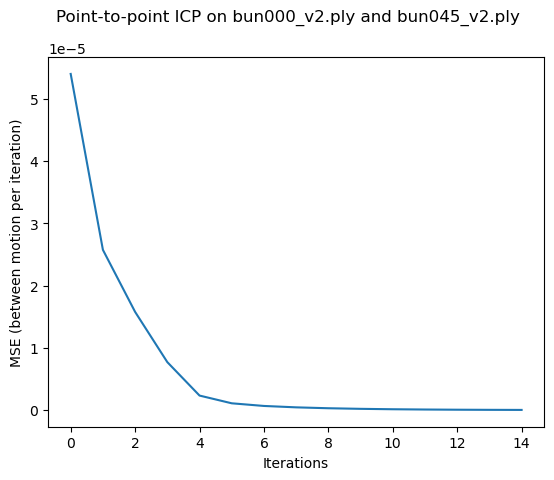

In [45]:
fig = plt.figure()
plt.plot(error)
fig.suptitle('Point-to-point ICP on bun000_v2.ply and bun045_v2.ply')
plt.ylabel('MSE (between motion per iteration)')
plt.xlabel('Iterations')

In [46]:
shading = {"width": 300, "height": 300}
pt = mp.plot(new, shading=shading, c='red')
pt.add_points(v_q, c='blue')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0075298…

1

## Performance on noisy samples

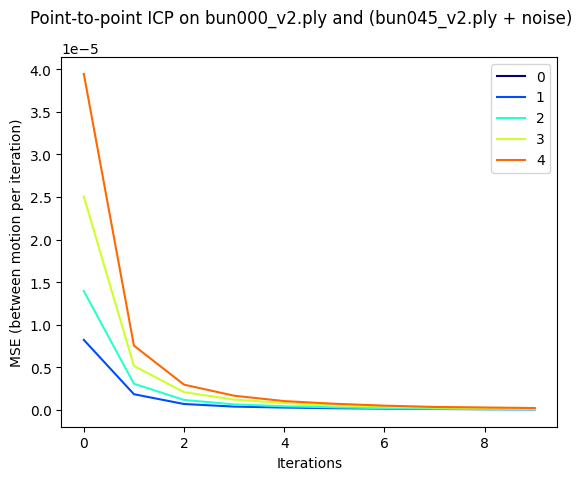

In [337]:
max_itrs = 10
tol = 1e-10

# create some colors for plotting
colors = plt.cm.jet(np.linspace(0,1,6))

temp_q = v_q.copy()
temp_p = v_p.copy()

# plot the baseline without any noise
error, _ = ICP_Basic(temp_p, temp_q, max_itrs, tol)

fig = plt.figure()
plt.plot(error, c=colors[0], label=0)
fig.suptitle('Point-to-point ICP on bun000_v2.ply and (bun045_v2.ply + noise)')
plt.ylabel('MSE (between motion per iteration)')
plt.xlabel('Iterations')

# compute sigma based on the size of the bounding box in each dimension
sigma_x = np.abs(np.min(temp_q[:, 0]) - np.max(temp_q[:, 0])) * 0.2
sigma_y = np.abs(np.min(temp_q[:, 1]) - np.max(temp_q[:, 1])) * 0.2
sigma_z = np.abs(np.min(temp_q[:, 2]) - np.max(temp_q[:, 2])) * 0.2

for i in range(4):
    temp_p = v_p.copy()
    temp_q = v_q.copy()
    l = temp_q.shape[0]
    
    # generate 0 mean gaussian noise with the sigma
    x_noise = np.random.normal(0, sigma_x, l)
    y_noise = np.random.normal(0, sigma_y, l)
    z_noise = np.random.normal(0, sigma_z, l)
    # add the generated noise to vertex positions
    noise = np.stack((x_noise, y_noise, z_noise)).reshape(l, 3)
    
    q_noise = temp_q + noise
    error, _ = ICP_Basic(temp_p, q_noise, max_itrs, tol)
    plt.plot(error, c=colors[i+1], label=i+1)

    # increase the sd by 25% each time
    sigma_x *= 1.25
    sigma_y *= 1.25
    sigma_z *= 1.25

plt.legend(loc="upper right")

# Point-to-point ICP + Subsampling + Rejection

## Rejection based on distance

In [11]:
def subsample_ICP(temp_p, temp_q_b_s, itrs, tol, samples):
    error = []
    # construct the KD tree on fixed points
    tree = KDTree(temp_p)

    for itr in range(itrs):        
        prev = temp_q_b_s.copy()

        # generate "samples" number of indicies randomly
        rand_index = np.random.randint(0, temp_q_b_s.shape[0], samples)
        temp_q = np.array([temp_q_b_s[i, :] for i in rand_index])

        # find the closest p for each point in q
        distance, idx = tree.query(temp_q)
        # store indices for correspondence
        pairs = []
        counter = 0
        for dist, i in zip (distance, idx):
            if dist <= np.median(distance) * 1.5:
                pairs.append([i[0], counter])
            counter += 1

        p = []
        q = []

        # use the stored indices to get vertex positions
        for pair in pairs:
            p_i = temp_p[pair[0]]
            q_i = temp_q[pair[1]]
            p.append(p_i)
            q.append(q_i)

        # center the vertex positions
        p_bar = np.mean(p, axis = 0)
        q_bar = np.mean(q, axis = 0)
        p_tilda = p - p_bar
        q_tilda = q - q_bar

        # perform SVD to solve the minimization in closed form
        A = np.dot(q_tilda.T, p_tilda)
        u, w, vt = np.linalg.svd(A)
        # compute rotation R and translation t
        R = vt.T @ u.T
        t = p_bar - R @ q_bar

        # update the moving points q to their new positions
        temp_q_b_s = temp_q_b_s @ R.T + t

        # compute change in q
        # stop iterating if movement is too small
        se = np.mean((prev - temp_q_b_s)**2)
        error.append(se)
        if se < tol:
            break

    return error, temp_q_b_s

## Rejection based on angles between normals

In [13]:
def subsample_ICP_Rejection(temp_p, temp_q_b_s, itrs, tol, samples, n_p, n_q):
    error = []
    # construct the KD tree on fixed points
    tree = KDTree(temp_p)

    for itr in range(itrs):        
        prev = temp_q_b_s.copy()

        # generate "samples" number of indicies randomly
        rand_index = np.random.randint(0, temp_q_b_s.shape[0], samples)
        temp_q = np.array([temp_q_b_s[i, :] for i in rand_index])
        sampled_n_q = np.array([n_q[i, :] for i in rand_index])

        # find the closest p for each point in q
        distance, idx = tree.query(temp_q)
        # store indices for correspondence
        pairs = []
        counter = 0
        for dist, i in zip (distance, idx):
            # threshold points pair with a maximum distance
            if dist <= np.median(distance) * 1.5:
                pairs.append([i[0], counter])
            counter += 1

        p = []
        q = []

        for pair in pairs:
            # use the stored indices to get vertex positions
            p_i = temp_p[pair[0]]
            q_i = temp_q[pair[1]]
            # use the stored indices to get the vertex normals
            # normalize to 1 and compute their angles using dot product
            n_p_i = n_p[pair[0]] / np.linalg.norm(n_p[pair[0]])
            n_q_i = sampled_n_q[pair[1]] / np.linalg.norm(sampled_n_q[pair[1]])
            angle = np.arccos(np.clip(np.dot(n_p_i, n_q_i), -1.0, 1.0))

            # threshold the angle by a max degree
            if angle <= np.deg2rad(100):
                p.append(p_i)
                q.append(q_i)

        # center the vertex position
        p_bar = np.mean(p, axis = 0)
        q_bar = np.mean(q, axis = 0)
        p_tilda = p - p_bar
        q_tilda = q - q_bar

        # perform SVD to solve the minimization in closed form
        A = np.dot(q_tilda.T, p_tilda)
        # compute rotation R and translation t
        u, w, vt = np.linalg.svd(A)
        R = vt.T @ u.T
        t = p_bar - R @ q_bar

        # update the moving points q to their new positions
        temp_q_b_s = temp_q_b_s @ R.T + t
        # rotate the normal vectors of the moving points to update their directions
        n_q = n_q @ R.T

        # compute change in q
        # stop iterating if movement is too small
        se = np.mean((prev - temp_q_b_s)**2)
        error.append(se)
        if se < tol:
            break

    return error, temp_q_b_s

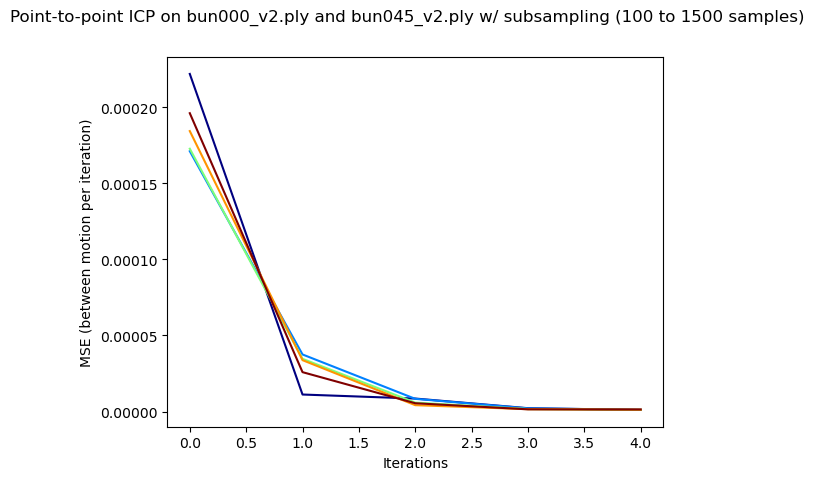

In [18]:
temp_p = v_p.copy()
temp_q = v_q.copy()
max_itrs = 5
tol = 1e-10

colors = plt.cm.jet(np.linspace(0,1,5))
samples = np.linspace(100, 1500, 5).astype(int)

fig = plt.figure()
fig.suptitle('Point-to-point ICP on bun000_v2.ply and bun045_v2.ply w/ subsampling (100 to 1500 samples)')
plt.ylabel('MSE (between motion per iteration)')
plt.xlabel('Iterations')

counter = 0
for sample in samples:
    temp_p = v_p.copy()
    temp_q = v_q.copy()
    error, _ = subsample_ICP(temp_p, temp_q, max_itrs, tol, sample)
    plt.plot(error, c=colors[counter])
    counter += 1

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.014824…

1

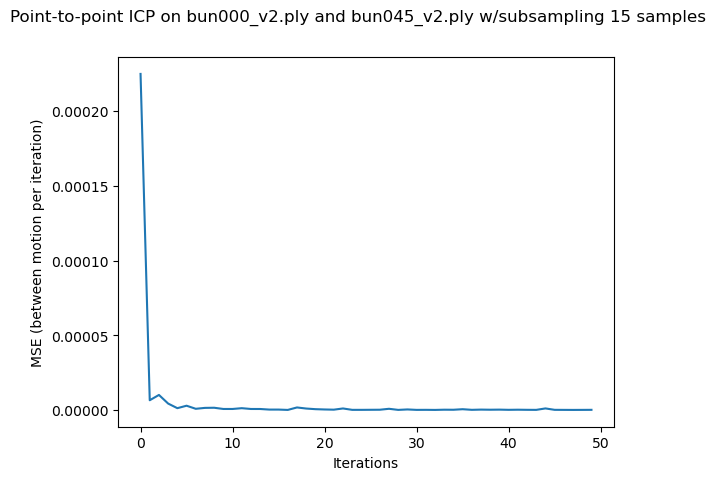

In [19]:
temp_p = v_p.copy()
temp_q = v_q.copy()
temp_n_p = n_p.copy()
temp_n_q = n_q.copy()
max_itrs = 50
tol = 1e-10
sample = 15

error, new = subsample_ICP(temp_p, temp_q, max_itrs, tol, sample)

fig = plt.figure()
plt.plot(error)
fig.suptitle('Point-to-point ICP on bun000_v2.ply and bun045_v2.ply w/subsampling 15 samples')
plt.ylabel('MSE (between motion per iteration)')
plt.xlabel('Iterations')

shading = {"width": 300, "height": 300}
pt = mp.plot(new, shading=shading, c='red')
pt.add_points(v_p, c='blue')


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.014885…

1

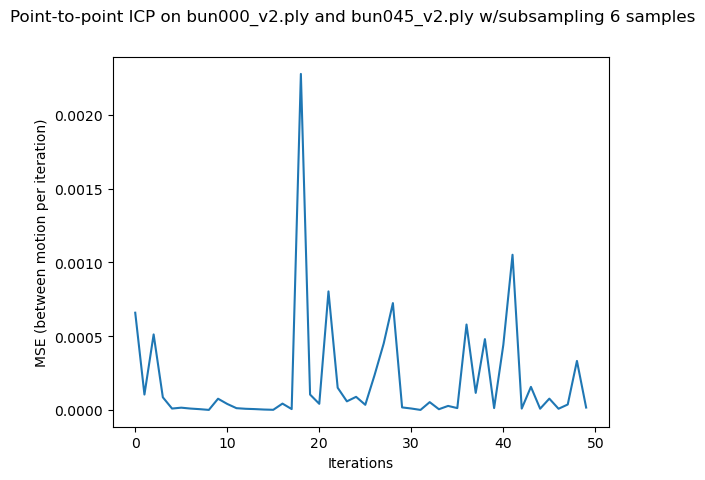

In [20]:
temp_p = v_p.copy()
temp_q = v_q.copy()
temp_n_p = n_p.copy()
temp_n_q = n_q.copy()
max_itrs = 50
tol = 1e-10
sample = 6

error, new = subsample_ICP(temp_p, temp_q, max_itrs, tol, sample)

fig = plt.figure()
plt.plot(error)
fig.suptitle('Point-to-point ICP on bun000_v2.ply and bun045_v2.ply w/subsampling 6 samples')
plt.ylabel('MSE (between motion per iteration)')
plt.xlabel('Iterations')

shading = {"width": 300, "height": 300}
pt = mp.plot(new, shading=shading, c='red')
pt.add_points(v_p, c='blue')


# Point-to-plane ICP

In [21]:
def rot_matrix(x, y, z):
    # creates a 3D rotation matrix
    # inputs x, y, and z are the angles of rotation for each axis 
    alpha, beta, gamma = z, y, x
    cos_alpha, sin_alpha = np.cos(alpha), np.sin(alpha)
    cos_beta, sin_beta = np.cos(beta), np.sin(beta)
    cos_gamma, sin_gamma = np.cos(gamma), np.sin(gamma)

    rot_m_r1 = [cos_alpha*cos_beta, cos_alpha*sin_beta*sin_gamma-sin_alpha*cos_gamma, cos_alpha*sin_beta*cos_gamma+sin_alpha*sin_gamma]
    rot_m_r2 = [sin_alpha*cos_beta, sin_alpha*sin_beta*sin_gamma+cos_alpha*cos_gamma, sin_alpha*sin_beta*cos_gamma-cos_alpha*sin_gamma]
    rot_m_r3 = [-sin_beta, cos_beta*sin_gamma, cos_beta*cos_gamma]

    rot_m = np.array([rot_m_r1, rot_m_r2, rot_m_r3])

    return rot_m

In [41]:
def Plane_ICP(temp_p, temp_q_b_s, itrs, tol, samples, temp_n_p, temp_n_q):
    error = []
    # construct the KD tree on fixed points
    tree = KDTree(temp_p)

    for itr in range(itrs):        
        prev = temp_q_b_s.copy()

        # generate "samples" number of indicies randomly
        rand_index = np.random.randint(0, temp_q_b_s.shape[0], samples)
        temp_q = np.array([temp_q_b_s[i, :] for i in rand_index])

        # find the closest p for each point in q
        distance, idx = tree.query(temp_q)
        # store indices for correspondence
        pairs = []
        counter = 0
        for dist, i in zip (distance, idx):
            pairs.append([i[0], counter])
            counter += 1

        p = []
        q = []
        n = []

        # use the stored indices to get vertex positions and normals
        for pair in pairs:
            p_i = temp_p[pair[0]]
            q_i = temp_q[pair[1]]
            n_i = temp_n_p[pair[0]]
            p.append(p_i)
            q.append(q_i)
            n.append(n_i)

        # convert lists to np arrays 
        p = np.array(p)
        q = np.array(q)
        n = np.array(n)

        # solve least squares Ax = b in closed form
        A = np.hstack((np.cross(q, n), n))
        b = -np.einsum('ij,ij->i', (q - p), n)
        x = np.linalg.inv(A.T @ A) @ A.T @ b

        # compute a rotation matrix with rot_x = x[0], rot_y = x[1], rot_z = x[2]
        R = rot_matrix(x[0], x[1], x[2])
        # get the translation vector from x
        t = x[3:]

        # update the moving points q to their new positions
        temp_q_b_s = temp_q_b_s @ R.T + t

        # compute change in q
        # stop iterating if movement is too small        
        se = np.mean((prev - temp_q_b_s)**2)
        error.append(se)
        if se < tol:
            break

        temp_n_q = temp_n_q @ R.T
        temp_n_q = temp_n_q / np.linalg.norm(temp_n_q, axis=1).reshape(-1,1)

    return error, temp_q_b_s, temp_n_q

Text(0.5, 0, 'Iterations')

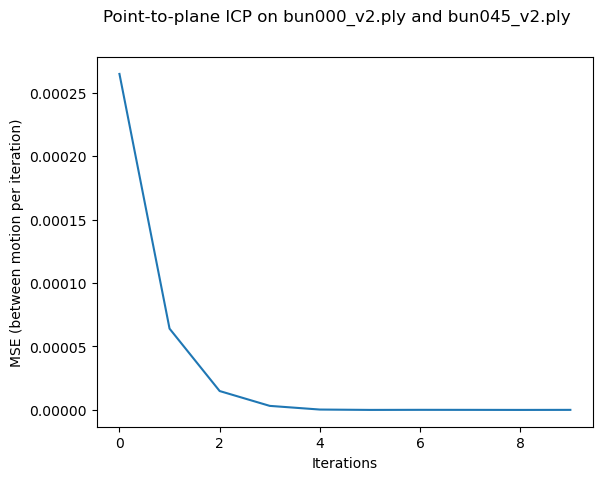

In [43]:
temp_p = v_p.copy()
temp_q = v_q.copy()
temp_n_p = n_p.copy()
temp_n_q = n_q.copy()
max_itrs = 10
tol = 1e-10

error, new, new_normals = Plane_ICP(temp_q, temp_p, max_itrs, tol, 1000, temp_n_q, temp_n_p)
fig = plt.figure()
plt.plot(error)
fig.suptitle('Point-to-plane ICP on bun000_v2.ply and bun045_v2.ply')
plt.ylabel('MSE (between motion per iteration)')
plt.xlabel('Iterations')

In [26]:
shading = {"width": 300, "height": 300}
pt = mp.plot(new, shading=shading, c=new_normals)
pt.add_points(v_p, c=n_p)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.014568…

1

In [27]:
shading = {"width": 300, "height": 300}
pt = mp.plot(new, shading=shading)
pt.add_points(v_p, c='blue')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.014568…

1